TODO:
* get rid of [-1, 2], make all final action positive
* in policy, do softmax, scale to [-1, 1], then in env scale back (already done)
* add profit rewards back in; hp tune?
* get rid of features=0 requirement (linear model?)

investigate size (should be 17, not 17*85 ??)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import stable_baselines3
from portfolio_env_framework import *
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy.typing as npt
import gymnasium as gym

In [66]:
class TrainDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size+1, 15), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+15]
        s = np.zeros((3, self.universe_size+1, 15))
        # s[1:, :-1] = self.ret[self.t:self.t+15, :].T

        # s[0, :-1, :] = self.stock_df.loc[self.times[t:t+15], :].to_numpy().T
        # s[1, :-1, :] = self.high_df.loc[self.times[t:t+15], :].to_numpy().T
        # s[2, :-1, :] = self.low_df.loc[self.times[t:t+15], :].to_numpy().T

        basis_mu = self.stock_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
        basis_std = self.stock_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
        # s[0, :-1, :] = (self.stock_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
        # s[0, :-1, :] = self.stock_df.loc[self.times[t:t+15], :].to_numpy().T
        s[0, :-1, :] = np.linspace(0, 1, 15).repeat(84).reshape(15, 84).T
        basis_mu = self.high_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
        basis_std = self.high_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
        # s[1, :-1, :] = (self.high_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
        s[1, :-1, :] = self.high_df.loc[self.times[t:t+15], :].to_numpy().T
        basis_mu = self.low_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
        basis_std = self.low_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
        # s[2, :-1, :] = (self.low_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
        s[2, :-1, :] = self.low_df.loc[self.times[t:t+15], :].to_numpy().T
        # print(f"{s=}")
        
        s[:, -1, :] = 1.0
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+15]
        return np.append(self.stock_df.loc[self.times[t+15], :].to_numpy().flatten(), 1.0)

In [67]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [68]:
class ProfitReward(AbstractRewardManager):
    def __init__(self):
        pass

    def initialize_reward(self):
        pass

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        return new_port_val - old_port_val

In [69]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size+1, 15), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df

        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+15]
        s = np.zeros((3, self.universe_size+1, 15))
        # s[1:, :-1] = self.ret[self.t:self.t+15, :].T

        # s[0, :-1, :] = self.stock_df.loc[self.times[t:t+15], :].to_numpy().T
        # s[1, :-1, :] = self.high_df.loc[self.times[t:t+15], :].to_numpy().T
        # s[2, :-1, :] = self.low_df.loc[self.times[t:t+15], :].to_numpy().T

        basis_mu = self.stock_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
        basis_std = self.stock_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
        # s[0, :-1, :] = (self.stock_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
        # s[0, :-1, :] = self.stock_df.loc[self.times[t:t+15], :].to_numpy().T
        s[0, :-1, :] = np.linspace(0, 1, 15)[None, :]
        basis_mu = self.high_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
        basis_std = self.high_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
        # s[1, :-1, :] = (self.high_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
        s[1, :-1, :] = self.high_df.loc[self.times[t:t+15], :].to_numpy().T
        basis_mu = self.low_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
        basis_std = self.low_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
        # s[2, :-1, :] = (self.low_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
        s[2, :-1, :] = self.low_df.loc[self.times[t:t+15], :].to_numpy().T
        # print(f"{s=}")
        
        s[:, -1, :] = 1.0
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+15]
        return np.append(self.stock_df.loc[self.times[t+15], :].to_numpy().flatten(), 1.0)

In [70]:
# class TestDataManager(AbstractDataManager):
#     def get_obs_space(self) -> gym.spaces.Box:
#         # return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size+1, 15), dtype=np.float32)
#         return gym.spaces.Dict({
#             'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size+1, 15), dtype=np.float32),
#             'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
#         })

#     def get_data(self) -> tuple[int, int]:
#         # read SNP data
#         df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
#         # convert datatypes
#         df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
#         df.date = pd.to_datetime(df.date)
#         df.FACPR = df.FACPR.fillna('0.0')
#         df.astype({
#             'PRC': float,
#             'VOL': float,
#             'ASKHI': float,
#             'BIDLO': float,
#             'FACPR': float
#         })
    
#         # drop duplicates and nans
#         df = df.drop_duplicates(subset=['date', 'TICKER'])
#         df.dropna(inplace=True)
    
#         # only include stocks that are present in all dates
#         ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
#         def is_max_val_count(ticker: str) -> bool:
#           return ticker_ok[ticker]
#         ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
#         df = df[ok]
#         df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
#         # create stock array
#         self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
#         self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
#         self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
#         # adjust for stock splits
#         facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
#         self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
#         self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
#         self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
#         # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
#         self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
#         # get times and dickers
#         self.times = df.date.unique()[1:]
#         self.tickers = df.TICKER.unique()
        
#         self.num_time_periods = len(self.times)-15-1
#         self.universe_size = len(self.tickers)
    
#         # read index data and compute volatilities
#         idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
#           'DATE': 'string',
#           'vwretd': float
#         })
#         idx_df.DATE = pd.to_datetime(idx_df.DATE)
#         idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
#         idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
#         idx_df.set_index('DATE', inplace=True)
#         self.idx_df = idx_df
#         # self.vol_20 = idx_df.vol_20
#         # self.vol_60 = idx_df.vol_60
    
#         # # get vix data
#         # vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
#         #   'Date': 'string',
#         #   'vix': float
#         # })
#         # vix_df.Date = pd.to_datetime(vix_df.Date)
#         # vix_df.set_index('Date', inplace=True)
#         # self.vix_df = vix_df.vix
        
#         self.num_time_periods = len(self.times)-15-1
#         self.universe_size = len(self.tickers)
#         return self.num_time_periods, self.universe_size
    
#     def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
#         # today is self.times[self.t+15]
#         s = np.zeros((3, self.universe_size+1, 15))
#         # s[1:, :-1] = self.ret[self.t:self.t+15, :].T

#         # s[0, :-1, :] = self.stock_df.loc[self.times[t:t+15], :].to_numpy().T
#         # s[1, :-1, :] = self.high_df.loc[self.times[t:t+15], :].to_numpy().T
#         # s[2, :-1, :] = self.low_df.loc[self.times[t:t+15], :].to_numpy().T

#         # basis = self.stock_df.loc[self.times[t], :].to_numpy().flatten()[:, None]
#         # s[0, :-1, :] = self.stock_df.loc[self.times[t:t+15], :].to_numpy().T / basis
#         # s[1, :-1, :] = self.high_df.loc[self.times[t:t+15], :].to_numpy().T / basis
#         # s[2, :-1, :] = self.low_df.loc[self.times[t:t+15], :].to_numpy().T / basis

#         basis_mu = self.stock_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
#         basis_std = self.stock_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
#         # s[0, :-1, :] = (self.stock_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
#         s[0, :-1, :] = self.stock_df.loc[self.times[t:t+15], :].to_numpy().T
#         basis_mu = self.high_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
#         basis_std = self.high_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
#         # s[1, :-1, :] = (self.high_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
#         s[1, :-1, :] = self.high_df.loc[self.times[t:t+15], :].to_numpy().T
#         basis_mu = self.low_df.loc[self.times[t:t+15], :].to_numpy().mean(axis=0)[:, None]
#         basis_std = self.low_df.loc[self.times[t:t+15], :].to_numpy().std(axis=0)[:, None]
#         # s[2, :-1, :] = (self.low_df.loc[self.times[t:t+15], :].to_numpy().T - basis_mu) / basis_std
#         s[2, :-1, :] = self.low_df.loc[self.times[t:t+15], :].to_numpy().T

#         s[:, -1, :] = 1.0
#         return {'data': s[None, :, :, :], 'weights': w[None, :]}

#     def get_prices(self, t: int) -> npt.NDArray[np.float64]:
#         # today is self.times[self.t+15]
#         return np.append(self.stock_df.loc[self.times[t+15], :].to_numpy().flatten(), 1.0)

In [71]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# class Custom_EIEE_CNN_Extractor(BaseFeaturesExtractor):
#     def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 85):
#         super(Custom_EIEE_CNN_Extractor, self).__init__(observation_space, features_dim)
#         n_channels, self.universe_size_w_rfa, data_len = observation_space['data'].shape
#         n_output_channels = 16
#         self.cnn = nn.Sequential(
#             nn.Conv2d(n_channels, 8, kernel_size=(1, 5)),
#             nn.ReLU(),
#             nn.Conv2d(8, n_output_channels, kernel_size=(1, data_len-4)),
#             nn.ReLU()
#         ).cuda()
#         # self.features_dim = self.universe_size_w_rfa

#     def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
#         x = self.cnn(observations['data'])
#         w = observations['weights'][:, None, :]
#         y = torch.cat((x.squeeze(-1), w), dim=1)
#         return y


class Custom_EIEE_CNN_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 85*6):
        super(Custom_EIEE_CNN_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size_w_rfa, data_len = observation_space['data'].shape
        n_output_channels = 16
        # self.cnn = nn.Sequential(
        #     nn.Conv1d(n_channels, 5, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(5, 7, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(7, 9, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(9, 11, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(11, 9, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(9, 7, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(7, 5, kernel_size=(data_len-12,)),
        #     nn.ReLU()
        # ).cuda()
        # self.cnn = nn.Sequential(
        #     nn.Conv1d(n_channels, 5, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(5, 7, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(7, 9, kernel_size=(3,)),
        #     nn.ReLU(),
        #     nn.Conv1d(9, 11, kernel_size=(data_len-6,)),
        # ).cuda()
        self.cnn = nn.Conv1d(n_channels, 11, (data_len,)).cuda()
        self.v_cnn = torch.vmap(self.cnn, in_dims=2, out_dims=2)

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        x = self.v_cnn(observations['data'])
        w = observations['weights'][:, None, :]
        y = torch.cat((x.squeeze(-1), w), dim=1)
        return y
        return torch.ones_like(y).to(device=y.device, dtype=y.dtype)
        return torch.ones_like(y.flatten(start_dim=1)).to(device=y.device, dtype=y.dtype)
        return y.flatten(start_dim=1)

In [72]:
class Custom_EIEE_Network(nn.Module):
    def __init__(self, observation_space: gym.spaces.Dict, input_features: int = 12, *args, **kwargs):
        super(Custom_EIEE_Network, self).__init__(*args, **kwargs)
        self.observation_space = observation_space
        self.net = nn.Sequential(
            nn.Linear(input_features, 1),
            # nn.ReLU(),
            # nn.Linear(3, 1),
        )
        # torch.nn.init.uniform_(self.net[4].weight, a=-0.003, b=0.005)
        # torch.nn.init.zeros_(self.net[4].weight)
        # torch.nn.init.constant_(self.net[4].bias, 1/85)
        self.vec_net = torch.vmap(torch.vmap(self.net))
        # print(f"{self.observation_space['data'].shape=}")
        # self.features_dim = observation_space['data'].shape[1]

    def forward(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # print(f"net features min={features.min()}, max={features.max()}, median={features.median()}, std={features.std()}")
        # print(f"{(features >= 0).sum() / features.numel() =}")
        # print(f"{features.shape=}")
        x = self.vec_net(torch.transpose(features, 1, 2)).squeeze(-1)
        # print(f"{x.shape=}")
        # print(f"x min={x.min()}, max={x.max()}, median={x.median()}, xhat std={x.std()}")
        # x_hat = nn.functional.tanh(5 * x)
        x_hat = 2 * nn.functional.softmax(5 * x, dim=1) - 1
        return x_hat
        # print(f"network {x=}")
        return x
        x_hat = 2 * nn.functional.softmax(5 * x, dim=1) - 1
        # return torch.ones_like(x.shape).to(device=x.device, dtype=x.dtype)
        # print(f"xhat min={x_hat.min()}, max={x_hat.max()}, median={x_hat.median()}, xhat std={x_hat.std()}")
        return x_hat
        # return nn.functional.softmax(x, dim=1)

In [73]:
from stable_baselines3.td3.policies import Actor
from stable_baselines3.common.policies import BaseModel
from stable_baselines3.common.preprocessing import get_action_dim

class CustomActor(Actor):
    def __init__(self, observation_space: gym.spaces.Dict, *args, **kwargs):
        super(CustomActor, self).__init__(observation_space, *args, **kwargs)
        self.mu = Custom_EIEE_Network(observation_space)

class DenseMlp(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int = 16,
        n_layers: int = 2,
        squash_output: bool = False,
    ):
        super(DenseMlp, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.squash_output = squash_output
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim + input_dim, hidden_dim)
        if output_dim > 0:
            self.output_layer = nn.Linear(hidden_dim + input_dim, output_dim)
        self.output_activation = nn.Tanh()

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        out_1 = F.relu(self.layer_1(input_tensor))
        input_2 = torch.cat([out_1, input_tensor], dim=1)
        out_2 = F.relu(self.layer_2(input_2))

        if self.output_dim < 0:
            return out_2

        input_3 = torch.cat([out_2, input_tensor], dim=1)
        out_3 = self.output_layer(input_3)

        if self.squash_output:
            out_3 = self.output_activation(out_3)
        return out_3

class DenseContinuousCritic(BaseModel):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        net_arch: list[int],
        features_extractor: nn.Module,
        features_dim: int,
        activation_fn: type[nn.Module] = nn.ReLU,
        normalize_images: bool = True,
        n_critics: int = 2,
        share_features_extractor: bool = True,
    ):
        super().__init__(
            observation_space,
            action_space,
            features_extractor=features_extractor,
            normalize_images=normalize_images,
        )

        action_dim = get_action_dim(self.action_space)

        self.share_features_extractor = share_features_extractor
        self.n_critics = n_critics
        self.q_networks = []
        features_dim = 13 * 85 # TODO: bad idea
        # print(f"{features_dim=}, {action_dim=}, {net_arch=}, {n_critics=}")
        for idx in range(n_critics):
            q_net = DenseMlp(features_dim, 1)
            # q_net = nn.Sequential(
            #     Custom_EIEE_Network(observation_space, input_features=13),
            #     # nn.Softmax(dim=1),
            #     nn.Linear(85, 1)
            # )
            self.add_module(f"qf{idx}", q_net)
            self.q_networks.append(q_net)

    def forward(self, obs: torch.Tensor, actions: torch.Tensor) -> tuple[torch.Tensor, ...]:
        # Learn the features extractor using the policy loss only
        # when the features_extractor is shared with the actor
        with torch.set_grad_enabled(not self.share_features_extractor):
            features = self.extract_features(obs, self.features_extractor)
        # print(f"{obs['data'].shape=}, {actions.shape=}, {features.shape=}, {actions[:, None, :].shape=}, {features.flatten(1, 2).shape=}")
        qvalue_input = torch.cat([features, actions[:, None, :]], dim=1).flatten(start_dim=1)
        # print(f"{qvalue_input.shape=}")
        return tuple(q_net(qvalue_input) for q_net in self.q_networks)

    def q1_forward(self, obs: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
        """
        Only predict the Q-value using the first network.
        This allows to reduce computation when all the estimates are not needed
        (e.g. when updating the policy in TD3).
        """
        with torch.no_grad():
            features = self.extract_features(obs, self.features_extractor)
        # print(f"features mean={features.mean().detach().cpu().numpy()}, std={features.std().detach().cpu().numpy()}")
        print(f"actions min={actions.detach().cpu().min()}, max={actions.detach().cpu().max()}, median={actions.median().detach().cpu().numpy()}, mean={actions.mean().detach().cpu().numpy()}, std={actions.std().detach().cpu().numpy()}")       
        q1 = self.q_networks[0](torch.cat([features, actions[:, None, :]], dim=1).flatten(start_dim=1))
        # print(f"q1 mean={q1.mean().detach().cpu().numpy()}, std={q1.std().detach().cpu().numpy()}")
        return q1
        return self.q_networks[0](torch.cat([features, actions[:, None, :]], dim=1))

In [74]:
from typing import Optional
from stable_baselines3.td3.policies import TD3Policy

class CustomTD3Policy(TD3Policy):
    def __init__(self, observation_space: gym.spaces.Dict, *args, **kwargs):
        super(CustomTD3Policy, self).__init__(observation_space, *args, **kwargs)
        self.observation_space = observation_space

    def make_actor(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomActor:
        actor_kwargs = self._update_features_extractor(self.actor_kwargs, features_extractor)
        return CustomActor(**actor_kwargs).to(self.device)

    def make_critic(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> DenseContinuousCritic:
        critic_kwargs = self._update_features_extractor(self.critic_kwargs, features_extractor)
        return DenseContinuousCritic(**critic_kwargs).to(self.device)

In [75]:
# Parallel environments
from stable_baselines3 import DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise

train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=ProfitReward(), cp=0.01, cs=0.01)
# vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
#     'dm': TrainDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.01, # 0.10/365,
#     'cs': 0.01, # 0.10/365
# })

# Set seeds
random.seed(42)
np.random.seed(42)
# train_env.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG(CustomTD3Policy, train_env, buffer_size=250, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_CNN_Extractor,
  'net_arch': [16, 16],
  'optimizer_class': torch.optim.AdamW
})
# }, action_noise=NormalActionNoise(mean=np.zeros((85,)), sigma=0.1),)
# model = DDPG('MultiInputPolicy', train_env, buffer_size=10**4, verbose=1, policy_kwargs={
#   'features_extractor_class': Custom_EIEE_CNN_Extractor,
#   'net_arch': [256, 64],
# }, action_noise=NormalActionNoise(mean=np.zeros((85,)), sigma=0.1),)
model.learn(total_timesteps=10_000, log_interval=1)
# model.save("cnn_portoflio_policy")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
s=array([[[0.00000000e+00, 7.14285714e-02, 1.42857143e-01, ...,
         8.57142857e-01, 9.28571429e-01, 1.00000000e+00],
        [0.00000000e+00, 7.14285714e-02, 1.42857143e-01, ...,
         8.57142857e-01, 9.28571429e-01, 1.00000000e+00],
        [0.00000000e+00, 7.14285714e-02, 1.42857143e-01, ...,
         8.57142857e-01, 9.28571429e-01, 1.00000000e+00],
        ...,
        [0.00000000e+00, 7.14285714e-02, 1.42857143e-01, ...,
         8.57142857e-01, 9.28571429e-01, 1.00000000e+00],
        [0.00000000e+00, 7.14285714e-02, 1.42857143e-01, ...,
         8.57142857e-01, 9.28571429e-01, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

       [[2.15590000e+02, 2.15230000e+02, 2.12000000e+02, ...,
         2.07500000e+02, 2.04700000e+02, 2.13710010e+02],
        [5.44700000e+01, 5.43900000e+01, 5.47800

KeyboardInterrupt: 

In [ ]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    rm=ProfitReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+15]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+15])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
    if terminated:
        break

env raw action.mean()=-0.9764705896377563, action.std()=0.0
in env self.reward=-0.401493930906051, rescaled len(action)=85, action.min()=0.011764705882352941, action.max()=0.011764705882352941, action.mean()=0.01176470588235294, action.std()=1.734723475976807e-18
action[-5:]=array([0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471]), [0.02240896 0.02268908 0.02296919 0.0232493  0.02352941]
env raw action.mean()=-0.9764705896377563, action.std()=0.0
in env self.reward=-0.401493930906051, rescaled len(action)=85, action.min()=0.011764705882352941, action.max()=0.011764705882352941, action.mean()=0.01176470588235294, action.std()=1.734723475976807e-18
action[-5:]=array([0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471]), [0.02240896 0.02268908 0.02296919 0.0232493  0.02352941]
env raw action.mean()=-0.9764705896377563, action.std()=0.0
in env self.reward=-0.401493930906051, rescaled len(action)=85, action.min()=0.011764705882352941, action.max()=0.011764705882352941, ac

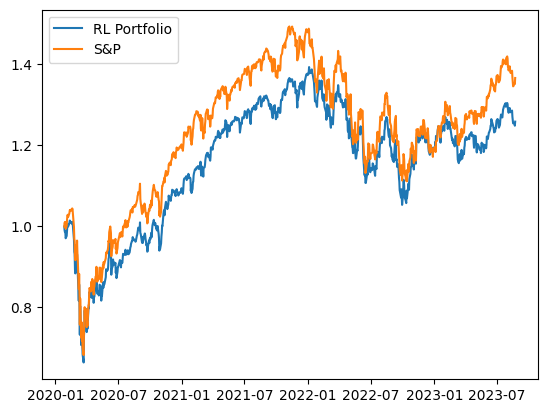

In [22]:
# linspace target, 0 features (expecting constant?)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [24]:
(actions[0]+1)/2

array([0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
       0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176

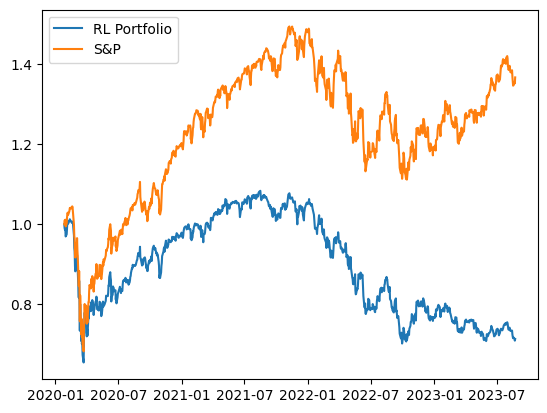

In [13]:
# linspace target, still no action noise, reward *100
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

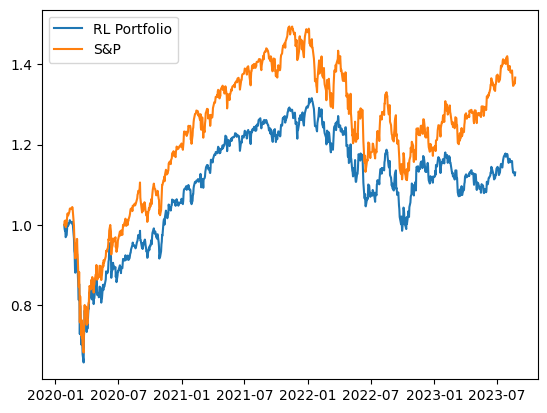

In [13]:
# linspace target, still no action noise
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [16]:
t = np.linspace(0, 1, len(actions[0]))
(actions[0]+1)/2 - t

array([ 1.06278062e-02,  4.78997117e-04, -1.11030056e-02, -2.61462799e-02,
       -3.54007809e-02, -4.73743266e-02, -5.85303647e-02, -7.05073078e-02,
       -9.51643345e-02, -9.70065211e-02, -1.06460817e-01, -1.18507587e-01,
       -1.30662986e-01, -1.42485106e-01, -1.61973665e-01, -1.66295584e-01,
       -1.77794796e-01, -1.90073010e-01, -2.02091170e-01, -2.13738231e-01,
       -2.25825235e-01, -2.39880383e-01, -2.49225483e-01, -2.61611463e-01,
       -2.73297625e-01, -2.85018059e-01, -2.96844054e-01, -3.08797811e-01,
       -3.20687850e-01, -3.32817918e-01, -3.44800792e-01, -3.56875486e-01,
       -3.68858599e-01, -3.80105891e-01, -3.92100627e-01, -4.04550145e-01,
       -4.16328724e-01, -4.40296363e-01, -4.39785001e-01, -4.52092511e-01,
       -4.63471352e-01, -4.75576177e-01, -4.87819850e-01, -4.99293760e-01,
       -5.11174174e-01, -5.23499565e-01, -5.34953508e-01, -5.52541602e-01,
       -5.58933858e-01, -5.73567231e-01, -5.82572794e-01, -5.94651631e-01,
       -6.06832124e-01, -

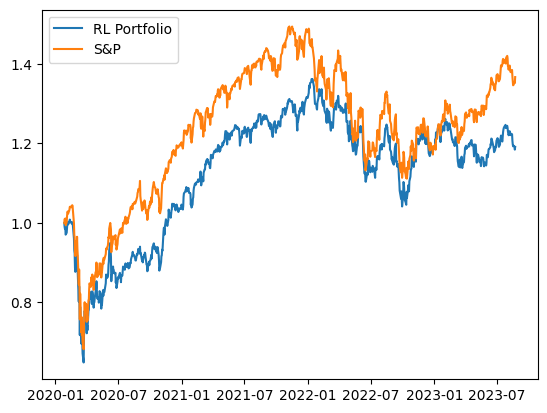

In [14]:
# const target, no action noise
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [15]:
actions[0]

array([-0.99374706, -0.97003567, -0.98675275, -0.99502707, -0.9640277 ,
       -0.96361256, -0.98946607, -0.98891914, -0.99999988, -0.99343169,
       -0.97701353, -0.99407107, -0.96083075, -0.963126  , -0.99867749,
       -0.96657121, -0.97946519, -0.96722972, -0.96313632, -0.9721846 ,
       -0.96619606, -0.99332476, -0.98403805, -0.96343648, -0.96805894,
       -0.97448647, -0.98316091, -0.98173112, -0.97912091, -0.97073859,
       -0.96825391, -0.96309954, -0.95580751, -0.98113823, -0.98409128,
       -0.95621037, -0.96585613, -0.99999809, -0.98994315, -0.98861766,
       -0.98409319, -0.97809708, -0.96529835, -0.97979277, -0.97798222,
       -0.96488178, -0.97853953, -0.99715859, -0.97521573, -0.9939701 ,
       -0.98709583, -0.97499043, -0.96400499, -0.98384011, -0.96382856,
       -0.97036332, -0.96472061, -0.98214877, -0.99466819, -0.9724077 ,
       -0.98994005, -0.96455711, -0.97867036, -0.96194124, -0.97631562,
       -0.96996707, -0.97052133, -0.97058976, -0.96325976, -0.96

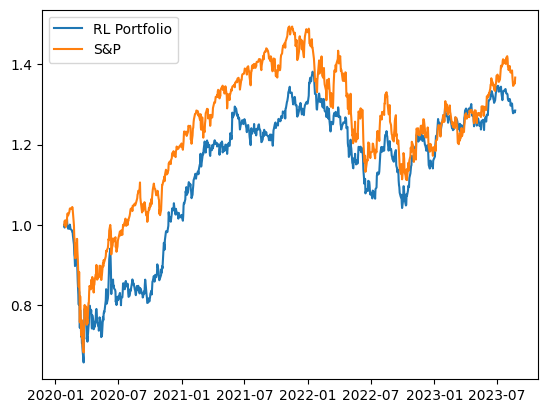

In [15]:
# target linspace, old testenv
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [19]:
actions[0]

array([-1.        , -0.99960387, -1.        , -1.        , -0.98954391,
       -0.98593718, -1.        , -1.        , -1.        , -1.        ,
       -0.99999321, -1.        , -0.94583362, -0.98536503, -1.        ,
       -0.99728799, -0.99999863, -0.99815255, -0.98192793, -0.99990946,
       -0.99683726, -1.        , -0.99999994, -0.98482531, -0.99873632,
       -0.99997491, -0.99999988, -0.99999964, -0.99999827, -0.99975985,
       -0.99900204, -0.98204005, -0.445306  , -0.99999958, -0.99999994,
       -0.55143201, -0.99642467, -1.        , -1.        , -1.        ,
       -0.99999994, -0.99999654, -0.9946177 , -0.99999869, -0.99999672,
       -0.99300128, -0.9999975 , -1.        , -0.99998277, -1.        ,
       -1.        , -0.9999792 , -0.98948222, -0.99999994, -0.98820442,
       -0.99971789, -0.99148583, -0.99999976, -1.        , -0.99991381,
       -1.        , -0.99189949, -0.99999702, -0.9676252 , -0.99998987,
       -0.99964195, -0.99973708, -0.99975002, -0.98404574, -0.99

In [18]:
(( (actions[0]+1)/2 - 1/len(actions[0]) )**2).sum()

0.22785438476982023

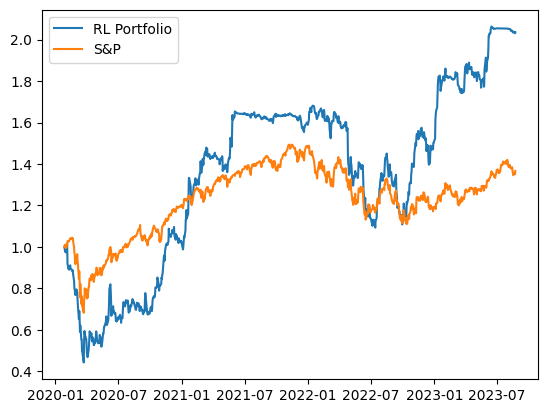

In [54]:
# target linspace, old testenv
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [55]:
actions[0]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  0.98939896, -1.        , -1.        ,
       -0.99331605, -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

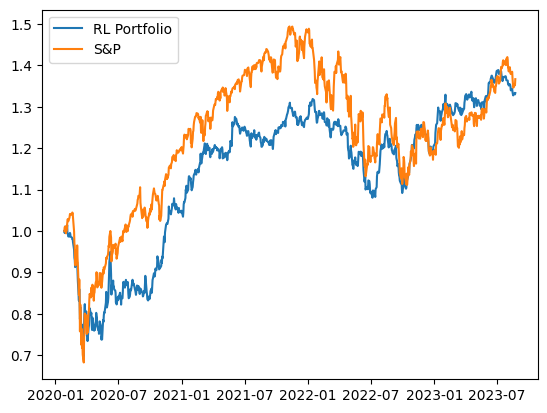

In [48]:
# target linspace, old testenv
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [49]:
actions[0]

array([[-1.        , -0.99999368, -1.        , -1.        , -0.99896687,
        -0.99837589, -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -0.9866994 , -0.99827063, -1.        ,
        -0.99987286, -1.        , -0.99993002, -0.99757922, -0.99999934,
        -0.99983883, -1.        , -1.        , -0.9981603 , -0.99996084,
        -0.99999988, -1.        , -1.        , -1.        , -0.99999708,
        -0.9999733 , -0.99761921, -0.44035375, -1.        , -1.        ,
        -0.61934519, -0.99980676, -1.        , -1.        , -1.        ,
        -1.        , -1.        , -0.99963671, -1.        , -1.        ,
        -0.99944669, -1.        , -1.        , -0.99999994, -1.        ,
        -1.        , -0.99999994, -0.99895972, -1.        , -0.99875325,
        -0.99999619, -0.99924582, -1.        , -1.        , -0.9999994 ,
        -1.        , -0.99930543, -1.        , -0.99399912, -1.        ,
        -0.99999458, -0.99999666, -0.9999969 , -0.9

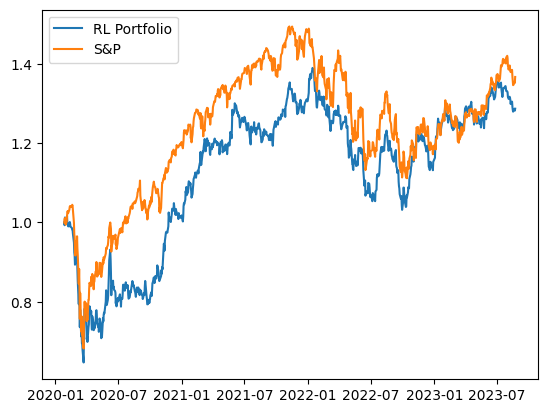

In [39]:
# target linspace
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [40]:
actions[0]

array([-1.        , -0.99978739, -1.        , -1.        , -0.99184513,
       -0.98883313, -1.        , -1.        , -1.        , -1.        ,
       -0.9999975 , -1.        , -0.95010859, -0.9879275 , -1.        ,
       -0.99817628, -0.99999952, -0.99881077, -0.98537719, -0.99995673,
       -0.99781168, -1.        , -1.        , -0.98789525, -0.99922615,
       -0.99998909, -1.        , -0.99999988, -0.9999994 , -0.99987745,
       -0.9993912 , -0.9853968 , -0.39252371, -0.99999988, -1.        ,
       -0.50213218, -0.99745029, -1.        , -1.        , -1.        ,
       -1.        , -0.99999881, -0.99612039, -0.99999958, -0.99999881,
       -0.99485469, -0.99999917, -1.        , -0.99999285, -1.        ,
       -1.        , -0.9999913 , -0.99180901, -1.        , -0.99074268,
       -0.99985051, -0.99370319, -0.99999994, -1.        , -0.99995923,
       -1.        , -0.99390084, -0.99999899, -0.97205436, -0.99999607,
       -0.9998045 , -0.99986023, -0.99986947, -0.98713076, -0.99

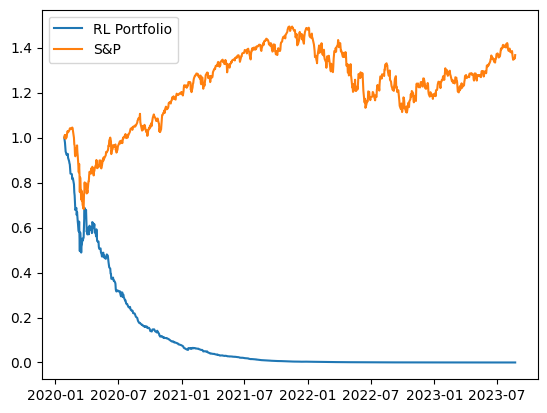

In [12]:
# target linspace
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [14]:
actions[0]

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -0.99999899, -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  0.99999833, -1.        , -1.        ,
        -1.        , -0.9999994 , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1. 

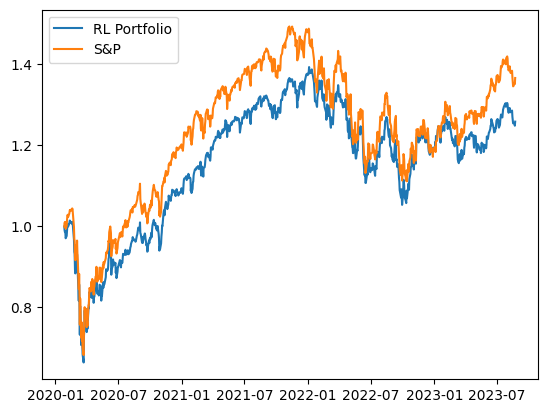

In [12]:
# -mse
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [16]:
rewards

0.0

In [13]:
actions[0]

array([[0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99998283, 0.99998283,
        0.99998283, 0.99998283, 0.99998283, 0.99

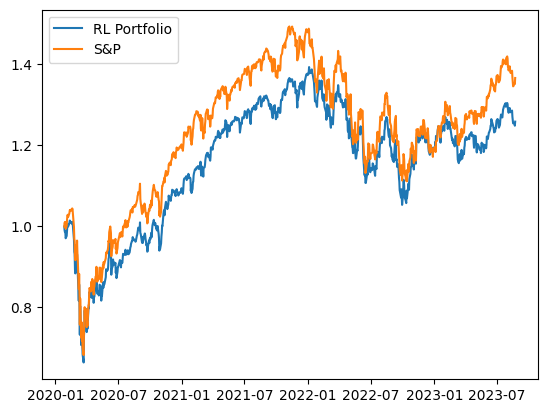

In [18]:
# profit - mse from const
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [19]:
actions

[array([[-0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.99936712, -0.99936712, -0.99936712,
         -0.99936712, -0.99936712, -0.

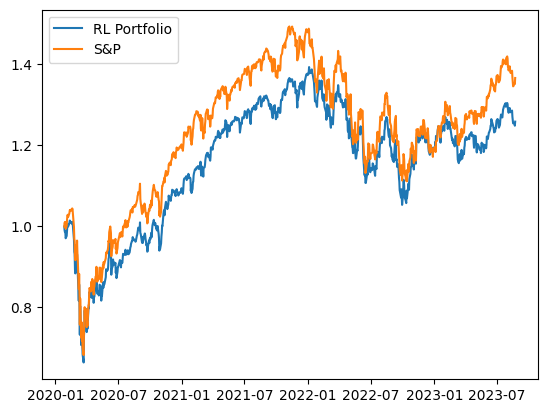

In [16]:
# asdf
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [13]:
actions

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

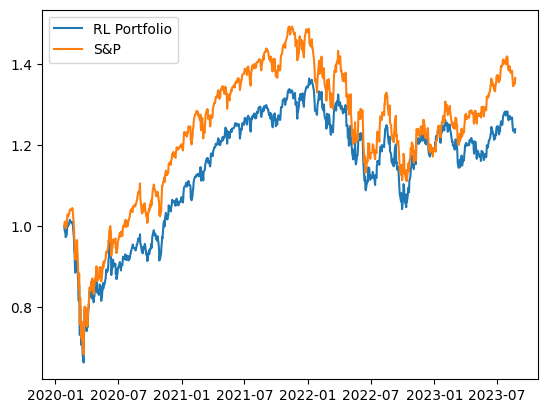

In [14]:
# asdf
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [15]:
actions

[array([[ 1.99997783, -0.96900412, -0.48412824,  1.99994886, -0.98374823,
         -0.99913535, -0.99504632,  1.22768241,  1.99256098,  1.98825997,
          1.98147881, -0.99566805,  1.99999607,  1.96541327,  1.99391961,
          1.99758476,  1.99567753,  1.98853874,  1.99857199, -0.9891552 ,
          1.9980334 ,  0.12769455, -0.99766102,  1.99861383,  1.99980617,
          1.97057045, -0.05024552,  1.99948716,  0.30340946,  1.98994422,
         -0.72961751,  1.99659467,  1.9453398 , -0.95634463, -0.99197188,
          1.96505654,  1.99989021, -0.90077159,  1.99998498, -0.41530937,
          1.99925667,  0.52328426,  1.9821254 , -0.98975137, -0.51346481,
         -0.93424547,  1.99999249,  1.99351567, -0.72391397,  1.99995458,
          1.90460116,  1.96562803,  1.99996603, -0.27307782, -0.99327177,
         -0.99896315, -0.99995512, -0.9398604 ,  1.97962987,  1.99997532,
         -0.97895995,  1.95253778, -0.74173403, -0.99184296,  1.97250181,
          1.99514145,  1.26676059,  0.

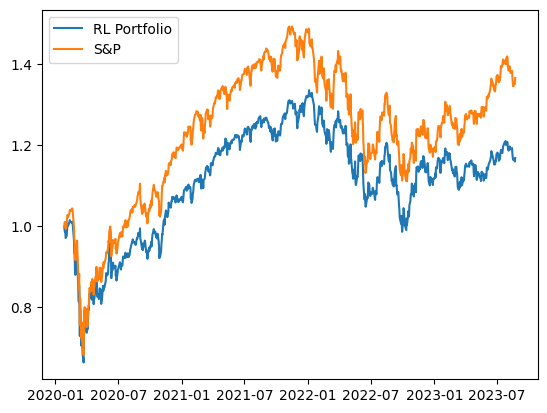

In [17]:
# kl divergence with uniform weights
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [18]:
actions[0]

array([[ 1.99999392, -0.99974886,  1.98848403, -0.99013922, -0.99997711,
         1.97544956, -0.99992946, -0.99971819,  1.99999911, -0.99882555,
        -0.99999964,  1.99617463, -0.99787247, -1.        ,  2.        ,
         1.9999603 , -0.99864575,  2.        , -0.99977523, -0.98940241,
        -0.99999848,  1.99999821, -0.99993187,  1.99999982, -0.99574745,
         2.        , -0.99999097, -0.96446958,  1.99966758, -0.99990657,
        -0.9402993 ,  1.99983549,  1.99999821,  1.73813397,  2.        ,
         2.        ,  1.99994743, -0.9998793 , -0.99253863, -0.99779665,
        -0.99622086, -0.99778566, -0.97916022, -0.99884093,  1.99982798,
        -0.831595  ,  1.99746585,  1.99609613, -0.99995995,  1.99857879,
        -0.98840365, -0.99987492, -0.99999544,  2.        , -0.99985141,
        -0.99829018,  1.99999821,  1.99999893, -0.99988306,  1.99670982,
        -0.83232349,  1.96847224,  1.99990737,  1.99883664, -1.        ,
        -0.99348938, -0.99998748, -1.        , -0.9

In [4]:
# action noise
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [5]:
actions[0]

NameError: name 'actions' is not defined

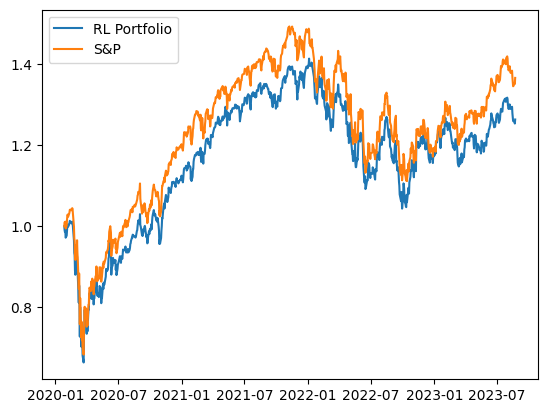

In [26]:
# scaled softmax instead of tanh
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [27]:
actions[0]

array([[ 2.        ,  2.        ,  2.        ,  2.        , -0.99999982,
        -1.        , -1.        , -1.        ,  2.        ,  2.        ,
         2.        ,  2.        , -1.        , -1.        ,  2.        ,
        -1.        , -1.        , -1.        ,  2.        ,  2.        ,
        -1.        ,  2.        ,  2.        , -0.99999911,  2.        ,
        -1.        ,  2.        , -1.        ,  2.        , -1.        ,
        -1.        , -1.        ,  2.        ,  2.        , -0.99999678,
        -1.        , -1.        , -1.        ,  2.        , -1.        ,
         2.        , -0.99999991,  2.        ,  2.        , -1.        ,
         2.        ,  2.        , -1.        ,  1.99999821,  2.        ,
        -1.        , -1.        ,  2.        ,  2.        , -1.        ,
         2.        ,  2.        ,  2.        ,  1.99999982,  2.        ,
        -1.        ,  2.        ,  2.        , -1.        , -1.        ,
        -1.        , -1.        ,  2.        , -1. 

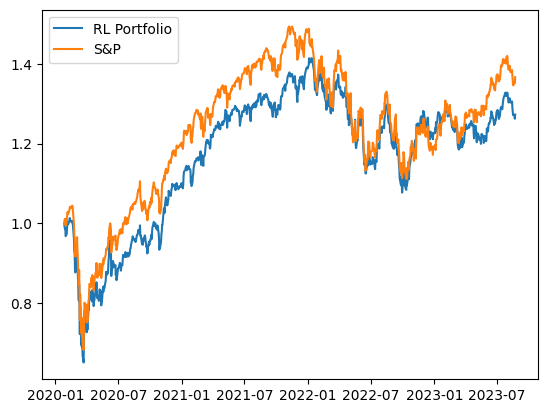

In [12]:
# big replay buffer
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [14]:
actions[0]

array([[ 2., -1., -1., -1.,  2.,  2., -1., -1., -1.,  2., -1.,  2., -1.,
        -1., -1.,  2.,  2.,  2., -1., -1., -1., -1., -1.,  2.,  2.,  2.,
         2., -1.,  2., -1., -1., -1.,  2.,  2.,  2.,  2., -1., -1.,  2.,
         2.,  2., -1.,  2.,  2.,  2., -1., -1., -1.,  2., -1., -1., -1.,
        -1.,  2., -1.,  2.,  2.,  2., -1., -1., -1., -1., -1., -1.,  2.,
         2., -1., -1.,  2.,  2.,  2., -1.,  2.,  2.,  2.,  2.,  2.,  2.,
         2., -1., -1., -1.,  2.,  2.,  2.]])

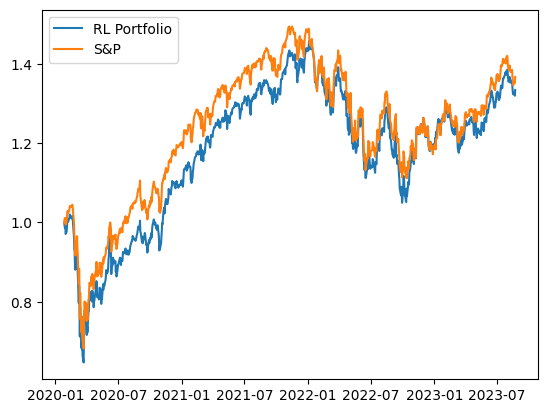

In [26]:
# extractor more layers
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [28]:
actions[0]

array([[ 2., -1.,  2.,  2.,  2.,  2., -1., -1., -1.,  2., -1.,  2.,  2.,
        -1.,  2., -1.,  2., -1.,  2., -1.,  2., -1.,  2.,  2., -1.,  2.,
        -1., -1.,  2., -1., -1., -1.,  2.,  2.,  2.,  2., -1.,  2.,  2.,
        -1., -1.,  2.,  2., -1.,  2., -1.,  2., -1., -1., -1.,  2., -1.,
        -1.,  2., -1.,  2.,  2.,  2.,  2., -1.,  2., -1., -1., -1.,  2.,
        -1.,  2., -1.,  2.,  2.,  2.,  2., -1.,  2.,  2.,  2.,  2., -1.,
        -1., -1., -1.,  2., -1., -1., -1.]])

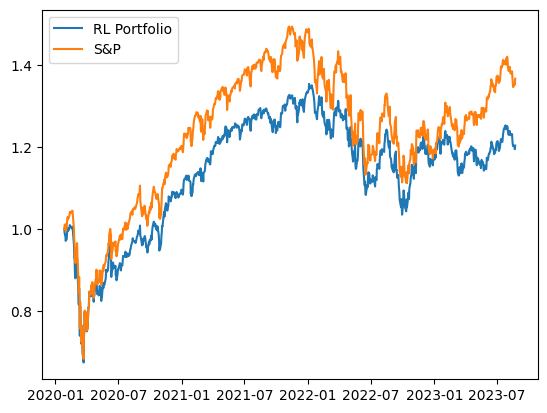

In [76]:
# small extractor
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [77]:
actions

[array([[-1., -1., -1.,  2., -1., -1., -1., -1.,  2., -1., -1., -1.,  2.,
         -1., -1.,  2.,  2.,  2.,  2., -1., -1.,  2., -1.,  2., -1.,  2.,
         -1.,  2., -1.,  2., -1., -1.,  2., -1., -1.,  2., -1., -1.,  2.,
         -1.,  2.,  2.,  2., -1.,  2., -1., -1.,  2.,  2.,  2., -1.,  2.,
         -1.,  2.,  2.,  2.,  2., -1., -1.,  2., -1., -1.,  2., -1.,  2.,
         -1.,  2.,  2.,  2., -1., -1.,  2.,  2.,  2., -1.,  2.,  2.,  2.,
         -1., -1., -1., -1.,  2.,  2.,  2.]]),
 array([[-1., -1., -1.,  2., -1., -1., -1., -1.,  2., -1., -1., -1.,  2.,
         -1., -1.,  2.,  2.,  2.,  2., -1., -1.,  2., -1.,  2., -1.,  2.,
         -1.,  2., -1.,  2., -1., -1.,  2., -1., -1.,  2., -1., -1.,  2.,
         -1.,  2.,  2.,  2., -1.,  2., -1., -1.,  2.,  2.,  2., -1.,  2.,
         -1.,  2.,  2.,  2.,  2., -1., -1.,  2., -1., -1.,  2., -1.,  2.,
         -1.,  2.,  2.,  2., -1., -1.,  2.,  2.,  2., -1.,  2.,  2.,  2.,
         -1., -1., -1., -1.,  2.,  2.,  2.]]),
 array([[-1., -1.,

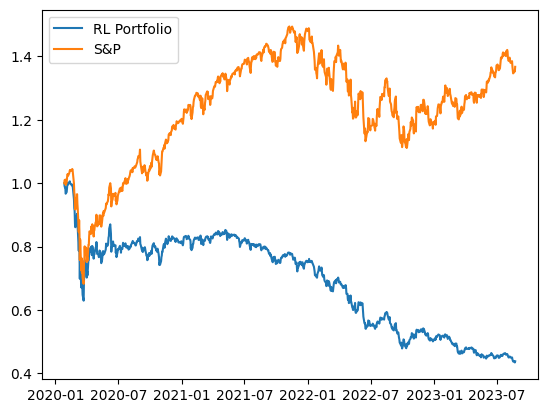

In [68]:
# no feature extractor
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

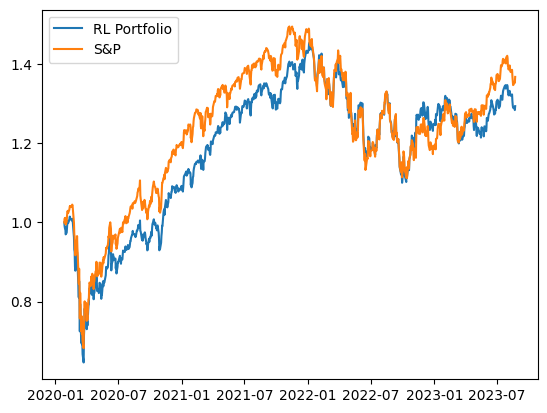

In [63]:
# full normaize
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [65]:
actions[0]

array([[-1.,  2., -1., -1., -1.,  2., -1.,  2.,  2.,  2.,  2.,  2., -1.,
         2.,  2.,  2., -1.,  2., -1., -1., -1., -1., -1.,  2.,  2.,  2.,
         2.,  2., -1., -1.,  2., -1.,  2., -1.,  2., -1., -1., -1.,  2.,
        -1., -1.,  2., -1., -1., -1., -1.,  2., -1.,  2., -1.,  2., -1.,
         2.,  2.,  2., -1.,  2.,  2., -1.,  2.,  2., -1.,  2.,  2., -1.,
         2.,  2., -1.,  2.,  2.,  2., -1., -1., -1., -1., -1., -1.,  2.,
        -1.,  2.,  2.,  2., -1.,  2., -1.]])

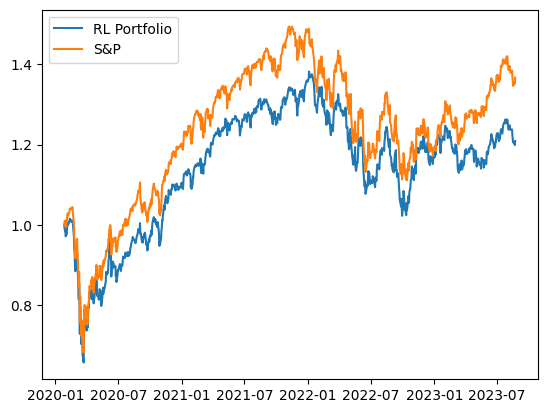

In [19]:
# rescaled actions, test
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [24]:
list(map(lambda x: (x == actions[0]).all(), actions))

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,


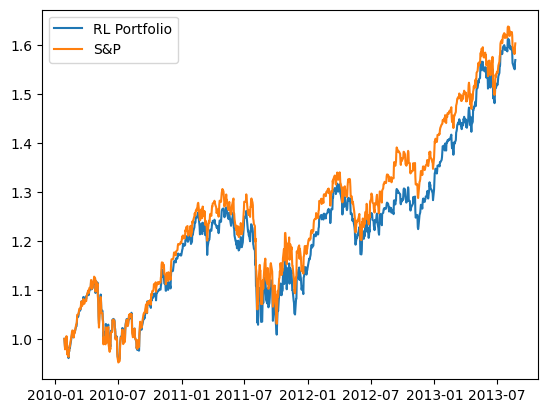

In [13]:
# rescaled actions
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [16]:
actions[0]

array([[ 2.,  2., -1., -1., -1.,  2., -1.,  2., -1.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2., -1.,  2., -1., -1., -1., -1.,
         2.,  2.,  2., -1.,  2.,  2.,  2.,  2.,  2.,  2.,  2., -1., -1.,
        -1.,  2.,  2., -1., -1., -1., -1., -1.,  2.,  2., -1., -1., -1.,
         2.,  2.,  2., -1., -1., -1.,  2.,  2., -1., -1.,  2., -1.,  2.,
        -1.,  2., -1.,  2.,  2., -1.,  2., -1., -1.,  2., -1.,  2., -1.,
        -1., -1.,  2.,  2.,  2., -1., -1.]])

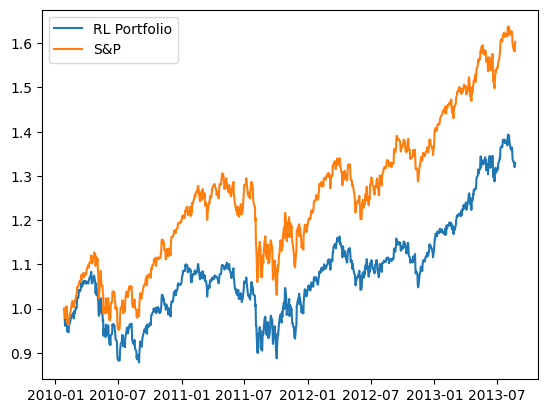

In [49]:
# now CNN extractor
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [50]:
actions[0]

array([[ 3.99999785,  4.        ,  3.99999964,  4.        ,  4.        ,
         4.        ,  3.99999785, -2.        ,  3.99999964, -1.99999875,
        -1.99998426,  4.        ,  4.        , -2.        ,  3.99999142,
         4.        , -1.99999893, -1.99999428,  4.        ,  3.99999928,
         3.99999607,  4.        , -1.99999928, -2.        ,  4.        ,
         3.9999907 , -2.        , -2.        , -2.        , -1.99998748,
        -1.99999124, -2.        ,  4.        ,  4.        , -2.        ,
        -1.99999857, -2.        ,  4.        ,  3.99999714, -2.        ,
         4.        , -1.99998802,  4.        ,  3.99999928,  4.        ,
        -1.99999982,  3.99999857, -2.        , -2.        , -2.        ,
         3.99999928,  4.        , -1.99999964, -1.99999982,  3.99999928,
        -2.        ,  4.        , -1.99999607, -2.        ,  4.        ,
         4.        , -2.        ,  4.        ,  4.        ,  4.        ,
         3.99997461, -2.        ,  4.        , -2. 

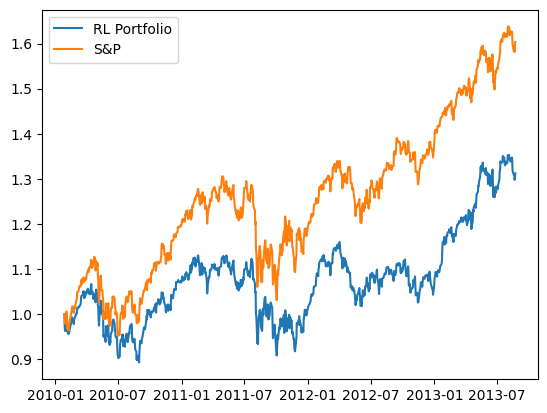

In [21]:
# MultiInputPolicy train data, w_lb=-2, w_ub=4
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [22]:
actions[0]

array([[ 4., -2., -2., -2., -2.,  4.,  4., -2., -2.,  4., -2., -2.,  4.,
        -2.,  4.,  4.,  4.,  4., -2., -2.,  4.,  4., -2.,  4., -2., -2.,
        -2., -2., -2.,  4.,  4., -2., -2.,  4., -2.,  4.,  4.,  4.,  4.,
         4.,  4.,  4., -2.,  4., -2.,  4.,  4., -2., -2., -2., -2.,  4.,
         4.,  4.,  4.,  4., -2.,  4.,  4., -2.,  4., -2., -2., -2., -2.,
         4., -2.,  4., -2., -2.,  4., -2.,  4.,  4., -2.,  4., -2.,  4.,
        -2., -2.,  4.,  4.,  4., -2., -2.]])

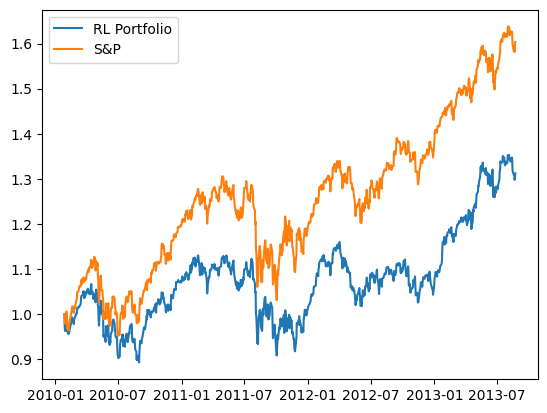

In [17]:
# MultiInputPolicy train data
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

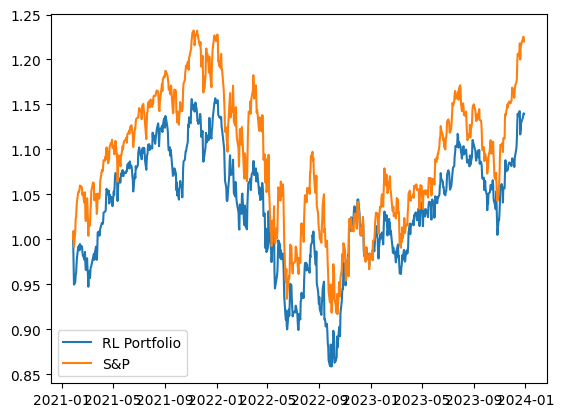

In [12]:
# MultiInputPolicy
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [14]:
actions[0]

array([[ 2., -1., -1., -1., -1.,  2.,  2., -1., -1.,  2., -1., -1.,  2.,
        -1.,  2.,  2.,  2.,  2., -1., -1.,  2.,  2., -1.,  2., -1., -1.,
        -1., -1., -1.,  2.,  2., -1., -1.,  2., -1.,  2.,  2.,  2.,  2.,
         2.,  2.,  2., -1.,  2., -1.,  2.,  2., -1., -1., -1., -1.,  2.,
         2.,  2.,  2.,  2., -1.,  2.,  2., -1.,  2., -1., -1., -1., -1.,
         2., -1.,  2., -1., -1.,  2., -1.,  2.,  2., -1.,  2., -1.,  2.,
        -1., -1.,  2.,  2.,  2., -1., -1.]])

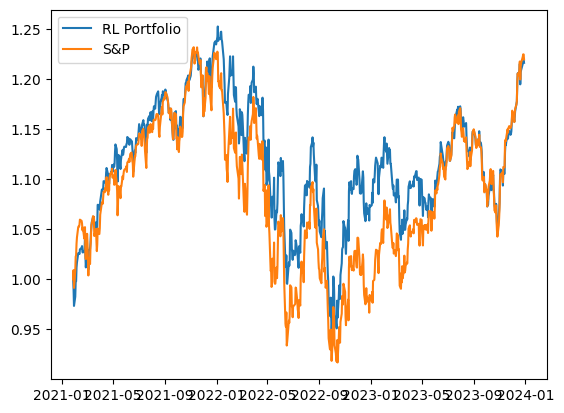

In [12]:
# 10*std(w[:-1])
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [20]:
actions[0][0][:-1].std()

0.0

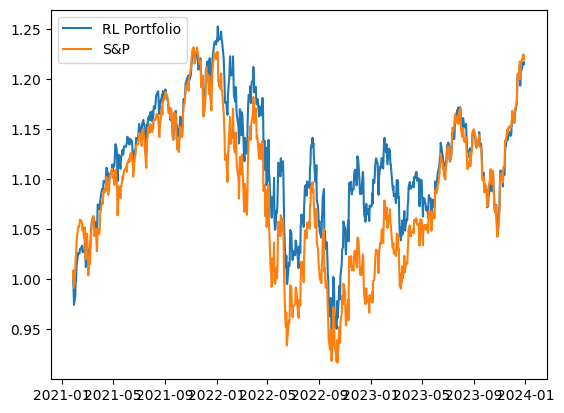

In [12]:
# 10*std(w)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

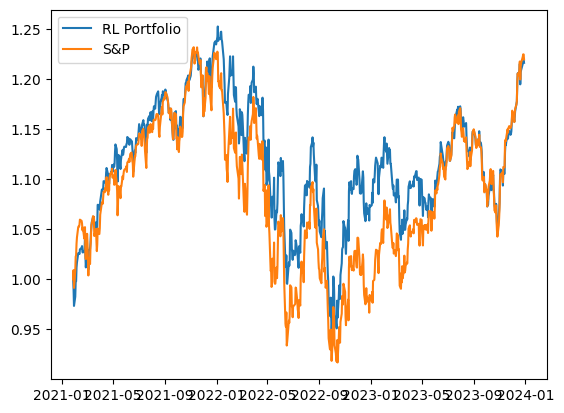

In [13]:
# std(w)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [16]:
actions[0].std()

0.0

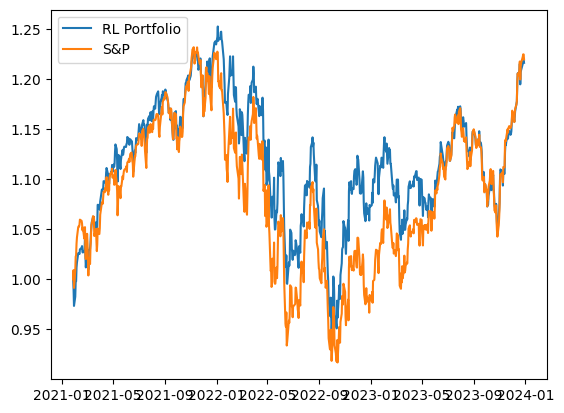

In [12]:
# normalized prices, tanh(20x)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [14]:
actions[0]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.]])

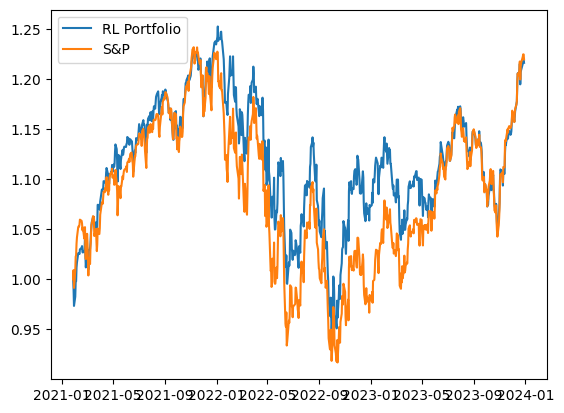

In [24]:
# manual init, trained 20k
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [27]:
np.unique(np.array(list(map(lambda a: len(np.unique(a)), actions))), return_counts=True)

(array([1, 2]), array([  2, 734], dtype=int64))

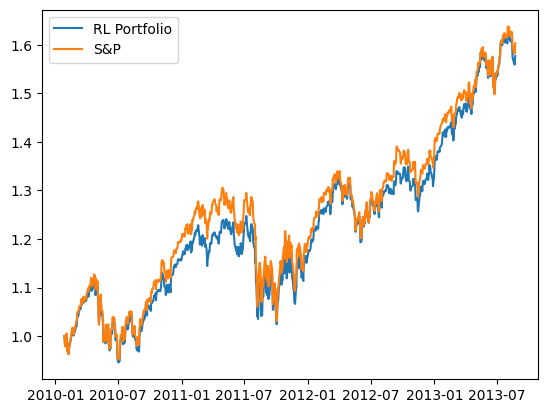

In [13]:
# manual init
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [15]:
actions[0]

array([[ 2.        ,  1.99986517,  1.99687362,  1.98526502,  1.91017425,
        -0.31376451,  1.99990112,  1.99773586,  2.        ,  1.22927243,
         1.99619484,  1.99996549,  0.90420818,  1.92085731,  2.        ,
         1.79736787,  1.99996781,  1.99999982,  0.94572556,  1.99590874,
         1.9997493 ,  1.99995047,  1.99999732,  1.76972628,  1.97290218,
         1.99999964,  1.99991328,  1.99999946,  1.95120525,  0.98659831,
         1.99783027,  1.99927473,  0.05522832,  2.        ,  1.99999714,
         0.91193134,  1.99824584,  2.        ,  2.        ,  1.90659046,
         1.99626315,  2.        ,  1.5018791 ,  1.99998802,  1.99752557,
         1.99989557,  1.98323619,  1.99999946,  1.69526118,  2.        ,
         1.99997979,  1.99839282,  1.99014735,  2.        ,  1.43406302,
         1.99164313,  1.95109063,  1.94218695,  1.99970424,  1.99998927,
         1.11707401,  1.78594971,  1.99997389,  1.2995404 ,  1.99996889,
         1.99937272,  1.99924326,  1.69751513,  1.3

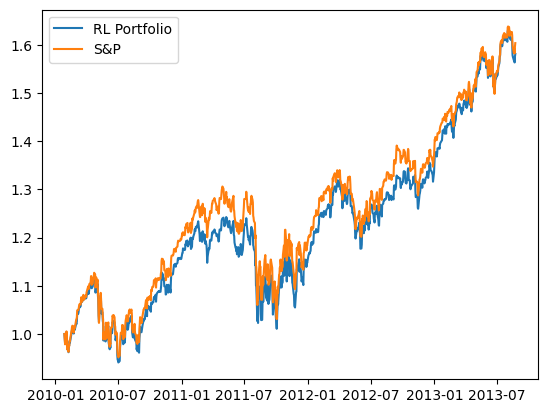

In [12]:
# tanh on network
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [16]:
actions[-1]

array([[ 2.,  2.,  2.,  2.,  2., -1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2., -1.]])

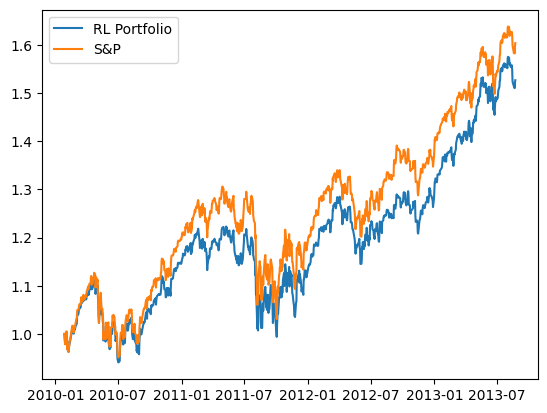

In [16]:
# tanh convnet, with softmax
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [17]:
actions[0].mean(), actions[0].std(), np.median(actions[0])

(0.5176470546161427, 0.08651185741163064, 0.5)

In [20]:
actions[0].min(), actions[0].max()

(0.5, 1.1723183989524841)

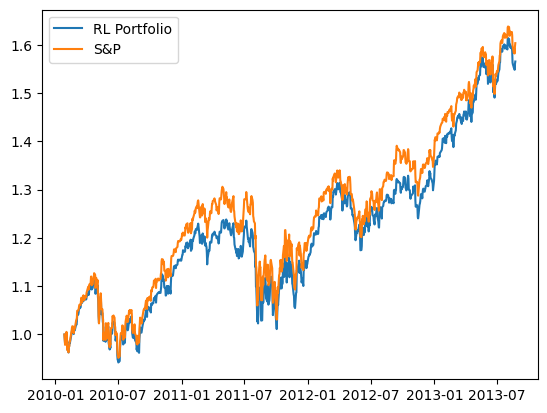

In [227]:
# train, with softmax
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

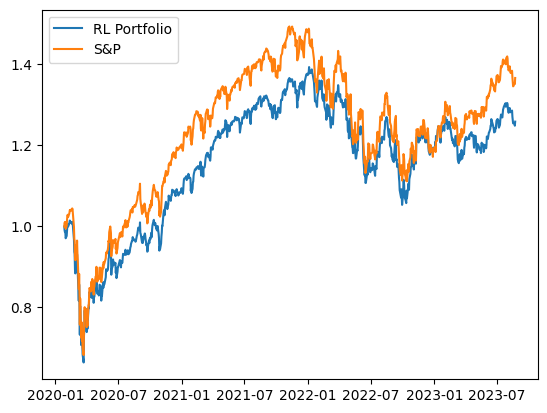

In [224]:
# with softmax, post 2020
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

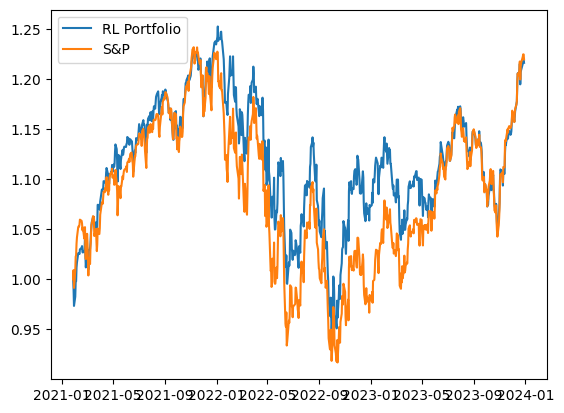

In [219]:
# with softmax, post 2021
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [221]:
np.unique(np.array(list(map(lambda a: len(np.unique(a)), actions))), return_counts=True)

(array([1, 2]), array([730,   6], dtype=int64))

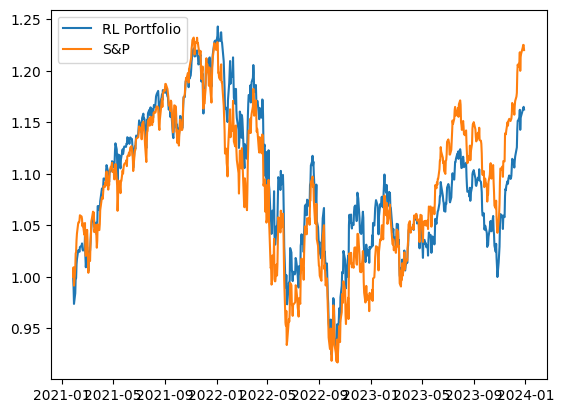

In [211]:
# profit reward, post 2021
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [214]:
actions[0]

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2. , 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [213]:
np.unique(np.array(list(map(lambda a: len(np.unique(a)), actions))), return_counts=True)

(array([2, 3]), array([733,   3], dtype=int64))

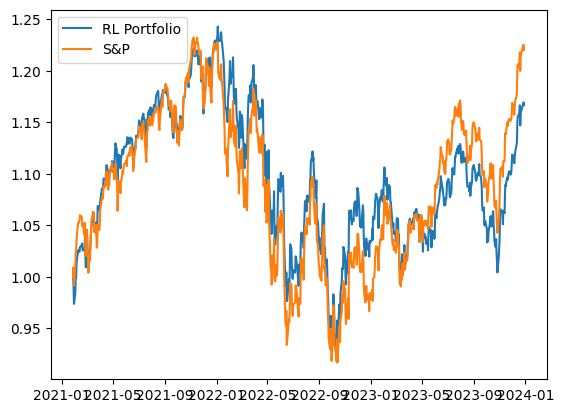

In [206]:
# decrease conv, post 2021
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

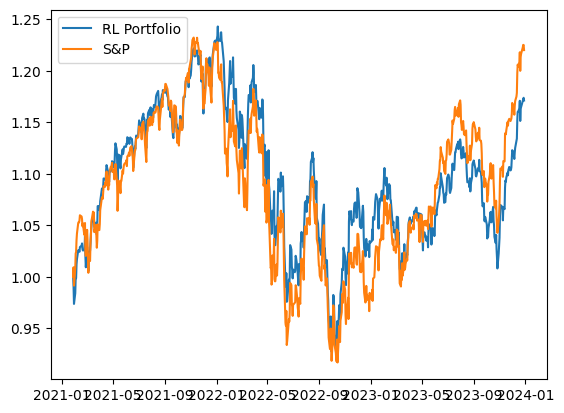

In [185]:
# 15lookback, 30k step, post 2021
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

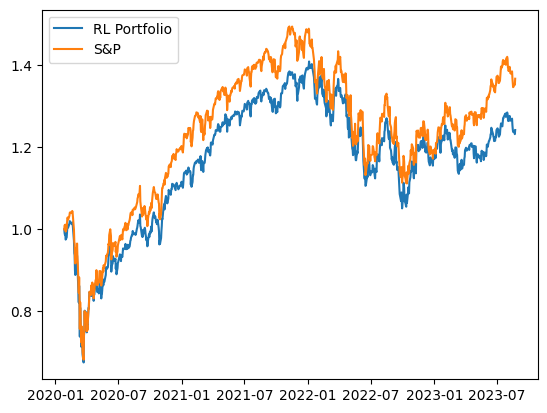

In [182]:
# 15 lookback, 30k step
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

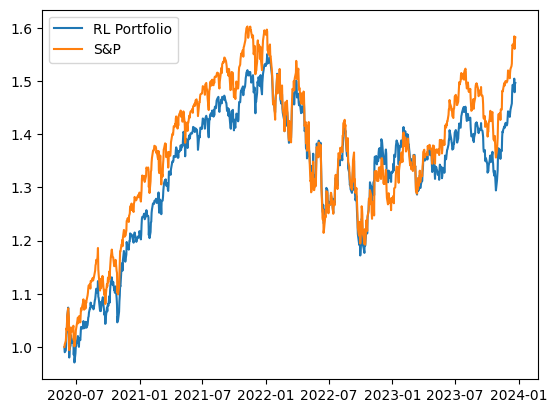

In [ ]:
# original (trained, 20k step)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
np.unique(np.array(list(map(lambda a: len(np.unique(a)), actions))), return_counts=True)

(array([1, 2]), array([896,   4], dtype=int64))

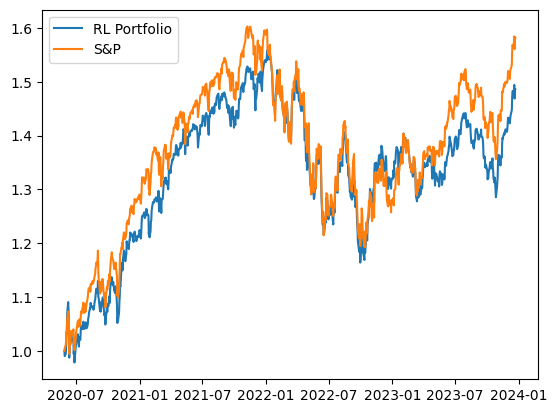

In [ ]:
# very original (not trained)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()